In [1]:
import warnings
import os
import sys

warnings.filterwarnings('ignore')
current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '../..'))
sys.path.append(parent_dir)


os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
from src.main.models.transformers import Transformer
from config import config
from src.main.pipeline.functions import clean_text, stop_words_removal
from src.main.utilities.utils import get_dataset, split_train_val_test
import numpy as np

inputs, targets = get_dataset(one_hot=False)

checkpoint = "roberta-base"

training_args = {
    'output_dir': config.RESULTS_DIRECTORY.format(checkpoint),
    'num_train_epochs': 5,
    'per_device_train_batch_size': 8,
    'per_device_eval_batch_size': 8,
    'learning_rate': 2e-5,
    'warmup_steps': 500,
    'weight_decay': 0.01,
    'logging_dir': config.LOGS_PATH.format(checkpoint),
    'logging_steps': 500,
    'evaluation_strategy': 'epoch',
    'save_strategy': 'epoch',
    'load_best_model_at_end': True,
    'metric_for_best_model': 'accuracy'
}

roberta = Transformer(checkpoint=checkpoint, **training_args)
roberta.pipeline = [clean_text, stop_words_removal]
inputs = roberta.run_pipeline(inputs, save=True)
targets = np.vectorize(config.label2id.get)(targets)

Map:   0%|          | 0/75407 [00:00<?, ? examples/s]

Map:   0%|          | 0/21546 [00:00<?, ? examples/s]

Map:   0%|          | 0/10773 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.435000,0.403236,0.882809,0.849997,0.821237,0.834491
2,0.388200,0.404816,0.891302,0.854282,0.837718,0.845467
3,0.335700,0.494944,0.893577,0.856759,0.841715,0.847200
4,0.230800,0.508845,0.895897,0.854860,0.851463,0.853048
5,0.191700,0.582834,0.897754,0.858978,0.850352,0.854511


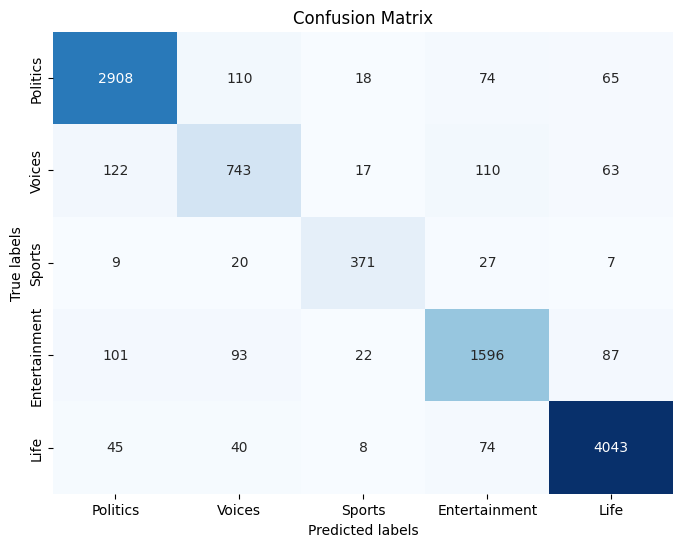

In [3]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_val_test(inputs, targets, validation_size=0.2, test_size=0.1)

training_dataset, validation_dataset, test_dataset = (
    roberta.prepare_dataset(x_train, y_train, x_val, y_val, x_test, y_test)
)

roberta.fit(training_dataset, validation_dataset)

roberta.save_results(test_dataset)
roberta.save_model()